In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
from concurrent.futures import ThreadPoolExecutor
import time
import gc

# Set random seeds for reproducibility
seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Constants
DATASET_DIR = "/kaggle/input/ucf-50/UCF50"
NO_OF_CLASSES = 12
CLASSES_LIST = os.listdir(DATASET_DIR)[:NO_OF_CLASSES]
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 15
DROPOUT_RATE = 0.5
MAX_VIDEO_PER_CLASS = 20
TEST_SIZE = 0.20
VALIDATION_SPLIT = 0.10
EPOCHS = 50
BATCH_SIZE = 8

# Define split directories
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Data Preparation Functions
def resize_and_normalize_frame(frame, image_height, image_width):
    """Resize and normalize a single frame."""
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return (normalized_frame * 255).astype(np.uint8)  # Convert back for saving
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, sequence_length=SEQUENCE_LENGTH, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    """Extract and process frames from a video."""
    frames = []
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frames.append(frame)
    video_reader.release()
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), frames))
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None
    return processed_frames

def copy_video_frames(video_paths, target_dir):
    """Copy extracted frames into target directory with class labels."""
    for video_path in video_paths:
        class_name = os.path.basename(os.path.dirname(video_path))
        label_dir = os.path.join(target_dir, class_name)
        os.makedirs(label_dir, exist_ok=True)
        frames = frames_extraction(video_path)
        if frames is not None:
            for i, frame in enumerate(frames):
                frame_path = os.path.join(label_dir, f"{os.path.basename(video_path)}_frame_{i}.jpg")
                cv2.imwrite(frame_path, frame)

# Split dataset
all_videos = []
for class_name in CLASSES_LIST:
    class_dir = os.path.join(DATASET_DIR, class_name)
    videos = [os.path.join(class_dir, vid) for vid in os.listdir(class_dir)[:MAX_VIDEO_PER_CLASS]]
    all_videos.extend([(vid, class_name) for vid in videos])

train_videos, temp_videos = train_test_split(
    all_videos,
    test_size=(TEST_SIZE + VALIDATION_SPLIT),
    stratify=[label for _, label in all_videos],
    random_state=42
)
val_videos, test_videos = train_test_split(
    temp_videos,
    test_size=(TEST_SIZE / (TEST_SIZE + VALIDATION_SPLIT)),
    stratify=[label for _, label in temp_videos],
    random_state=42
)

# Copy frames to directories
copy_video_frames([vid for vid, _ in train_videos], train_dir)
copy_video_frames([vid for vid, _ in val_videos], val_dir)
copy_video_frames([vid for vid, _ in test_videos], test_dir)

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(NO_OF_CLASSES, activation='softmax')(x)  # Multi-class output

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Start profiling
tf.keras.backend.clear_session()
tf.profiler.experimental.start('logdir/profile')

start_time = time.time()
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights
)
print("Initial training time: {:.2f} seconds".format(time.time() - start_time))

# Stop profiling
tf.profiler.experimental.stop()

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
start_time = time.time()
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights
)
print("Fine-tuning training time: {:.2f} seconds".format(time.time() - start_time))

# Evaluate the model on the test set
start_time = time.time()
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
print("Test evaluation time: {:.2f} seconds".format(time.time() - start_time))



2025-07-01 10:33:28.984577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751366009.158080      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751366009.206765      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2505 images belonging to 12 classes.
Found 360 images belonging to 12 classes.
Found 735 images belonging to 12 classes.
Training samples: 2505
Validation samples: 360
Test samples: 735
Class Weights: {0: 0.9940476190476191, 1: 0.9940476190476191, 2: 0.9940476190476191, 3: 0.9940476190476191, 4: 0.9940476190476191, 5: 0.9940476190476191, 6: 1.0705128205128205, 7: 0.9940476190476191, 8: 0.9940476190476191, 9: 0.9940476190476191, 10: 0.9940476190476191, 11: 0.9940476190476191}


I0000 00:00:1751366037.486950      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751366063.915305    4731 service.cc:148] XLA service 0x7c22500a7cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751366063.916104    4731 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751366066.731134    4731 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/314 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.0625 - loss: 3.5195       

I0000 00:00:1751366078.034319    4731 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


314/314 ━━━━━━━━━━━━━━━━━━━━ 85s 164ms/step - accuracy: 0.3084 - loss: 2.2391 - val_accuracy: 0.8972 - val_loss: 0.4035
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.7810 - loss: 0.6739 - val_accuracy: 0.9028 - val_loss: 0.3010
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8761 - loss: 0.3828 - val_accuracy: 0.9056 - val_loss: 0.2456
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.9097 - loss: 0.2841 - val_accuracy: 0.9444 - val_loss: 0.2162
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9199 - loss: 0.2514 - val_accuracy: 0.9361 - val_loss: 0.2177
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9517 - loss: 0.1698 - val_accuracy: 0.9389 - val_loss: 0.2675
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9508 - loss: 0.1547 - val_accuracy: 0.9278 - val_loss: 0.2266
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.9429 - loss: 0.1813 - val_accura

NameError: name 'plt' is not defined

In [3]:
import matplotlib.pyplot as plt

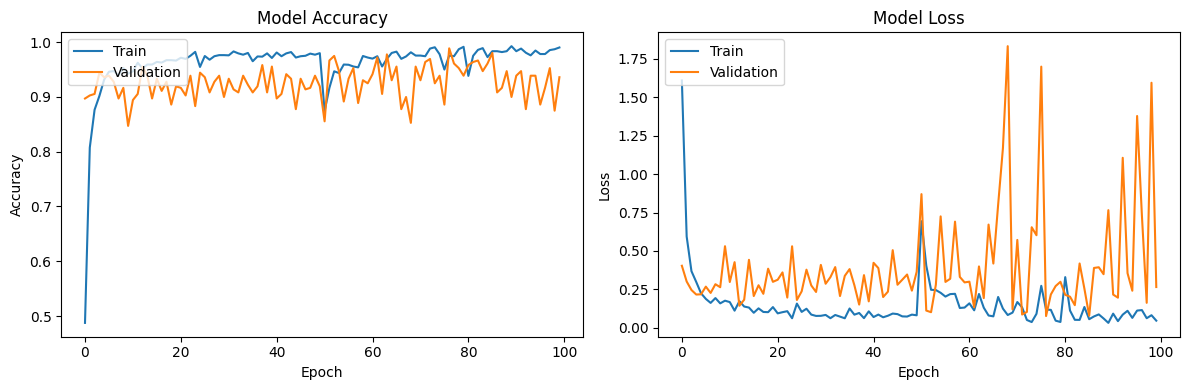

In [4]:
# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9224 - loss: 0.4221
Test Loss: 0.6269, Test Accuracy: 0.9129
Test evaluation time: 2.01 seconds
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step
Confusion Matrix:
[[60  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 37  0  1  0  8  0  5  0  4  2  0]
 [ 0  0 60  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 60  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 60  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 57  0  3  0  0  0  0]
 [ 0  0  0  0  0  0 75  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 58  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 55  0  5  0]
 [ 0  0  0  0 10  0  0  3  0 45  0  2]
 [15  0  0  0  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 59]]


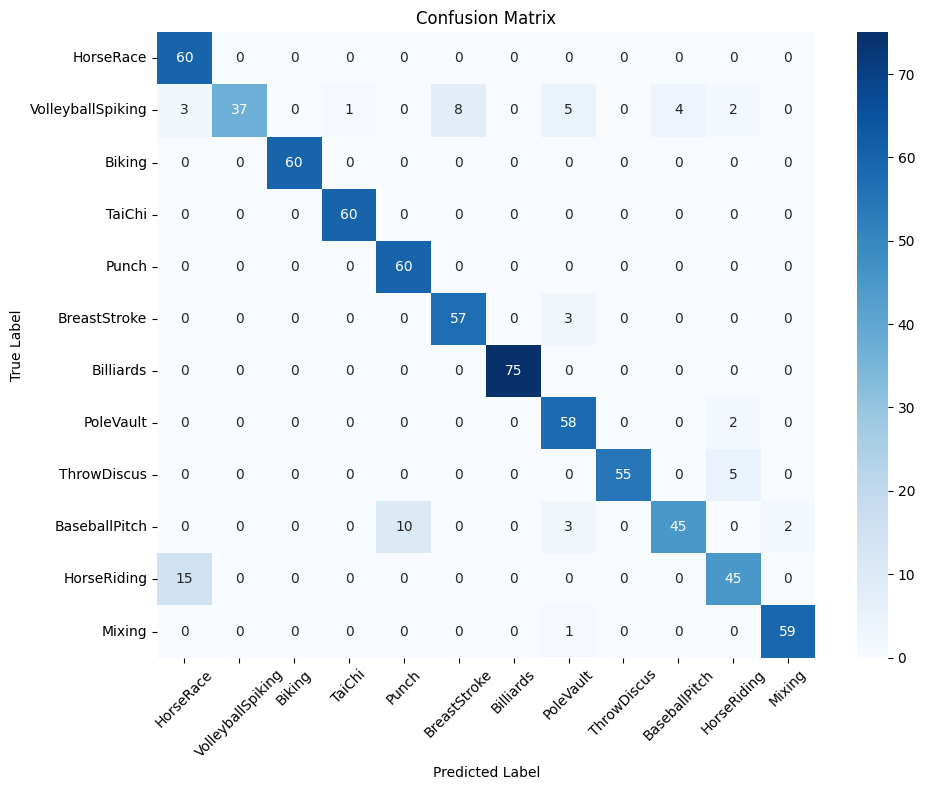

Confusion matrix computation time: 25.87 seconds


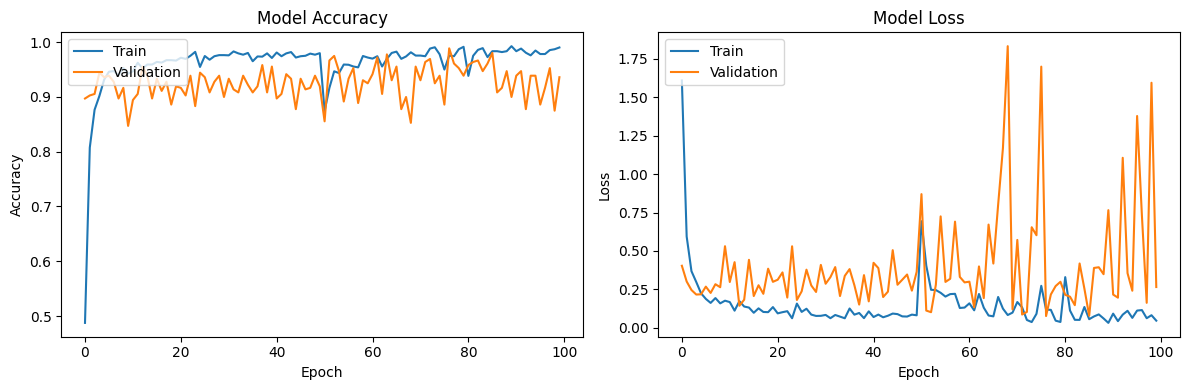

In [7]:
# Evaluate the model on the test set
start_time = time.time()
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
print("Test evaluation time: {:.2f} seconds".format(time.time() - start_time))

# Compute and visualize confusion matrix
start_time = time.time()
# Get predictions
test_generator.reset()  # Reset generator to start from beginning
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(f"Confusion matrix computation time: {time.time() - start_time:.2f} seconds")

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()